In [75]:
import re
import pandas as pd
import numpy as np
import openpyxl
import statsmodels.api as sm
import statsmodels.formula.api as smf
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
sp = spacy.load('en_core_web_sm')


In [76]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Merge datasets

In [77]:
# Upload and read the data

df_BCN_16=pd.read_excel('/content/barcelona_16_18.xlsx')
df_BCN_30=pd.read_excel('/content/barcelona_30_01.xlsx')
df_SVL_16=pd.read_excel('/content/seville_16_18.xlsx')
df_SVL_30=pd.read_excel('/content/seville_30_01.xlsx')

In [78]:
# Map description from df_BCN_30 to df_BCN_16
description_mapping = df_BCN_30[['name', 'description']].drop_duplicates()
df_BCN_16 = df_BCN_16.merge(description_mapping, on='name', how='left')

# Get common hotels
common_hotels = set(df_BCN_30['name']).intersection(set(df_BCN_16['name']))

# Filter dataframes to keep only common hotels
df_BCN_30 = df_BCN_30[df_BCN_30['name'].isin(common_hotels)]
df_BCN_16 = df_BCN_16[df_BCN_16['name'].isin(common_hotels)]

# Add treatment indicators
# We give '1' to hotels in Barcelona as treatment group
# We give '1' to time_period as post time period
df_BCN_30['city'] = 1
df_BCN_30['time_period'] = 1
df_BCN_16['city'] = 1
df_BCN_16['time_period'] = 0

# Merge dataframes
df_BCN = pd.concat([df_BCN_30, df_BCN_16], axis=0)

<ipython-input-78-37ea1fdc7ed9>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_BCN_30['city'] = 1
<ipython-input-78-37ea1fdc7ed9>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_BCN_30['time_period'] = 1


In [79]:
# Map description from df_SVL_30 to df_SVL_16
description_mapping = df_SVL_30[['name', 'description']].drop_duplicates()
df_SVL_16 = df_SVL_16.merge(description_mapping, on='name', how='left')

# Get common hotels
common_hotels = set(df_SVL_30['name']).intersection(set(df_SVL_16['name']))

# Filter dataframes to keep only common hotels
df_SVL_30 = df_SVL_30[df_SVL_30['name'].isin(common_hotels)]
df_SVL_16 = df_SVL_16[df_SVL_16['name'].isin(common_hotels)]

# Add treatment indicators
df_SVL_30['city'] = 0
df_SVL_30['time_period'] = 1
df_SVL_16['city'] = 0
df_SVL_16['time_period'] = 0

# Merge dataframes
df_SVL = pd.concat([df_SVL_30, df_SVL_16], axis=0)

In [80]:
df_final = pd.concat([df_BCN, df_SVL], axis=0)

# Preprocess and word cloud

In [81]:
# Define preprocessing function
def preprocess_text(text):
    # Handle NaN values
    if pd.isna(text):
        return ''

    # Convert to lowercase
    text = str(text).lower()

    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    # Add custom stopwords
    custom_stopwords = {'hotel', 'located', 'offers', 'featuring', 'including', 'provided'}
    stop_words.update(custom_stopwords)
    tokens = [token for token in tokens if token not in stop_words]

    # Stemming
    porter = PorterStemmer()
    tokens = [porter.stem(token) for token in tokens]

    return ' '.join(tokens)

In [82]:
# Combine all descriptions for each city
df_BCN_desc = ' '.join(df_BCN['description'].fillna(''))
df_SVL_desc = ' '.join(df_SVL['description'].fillna(''))

In [83]:
# Generate wordcloud objects
wordcloud_bcn = WordCloud(width=800, height=600, background_color='white').generate(df_BCN_desc)
wordcloud_svl = WordCloud(width=800, height=600, background_color='white').generate(df_SVL_desc)

# Save Barcelona wordcloud
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud_bcn, interpolation='bilinear')
plt.axis('off')
plt.title('Barcelona Hotels - Before Preprocessing')
plt.savefig('BCN_before.png', bbox_inches='tight', pad_inches=0)
plt.close()

# Save Seville wordcloud
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud_svl, interpolation='bilinear')
plt.axis('off')
plt.title('Seville Hotels - Before Preprocessing')
plt.savefig('SVL_before.png', bbox_inches='tight', pad_inches=0)
plt.close()

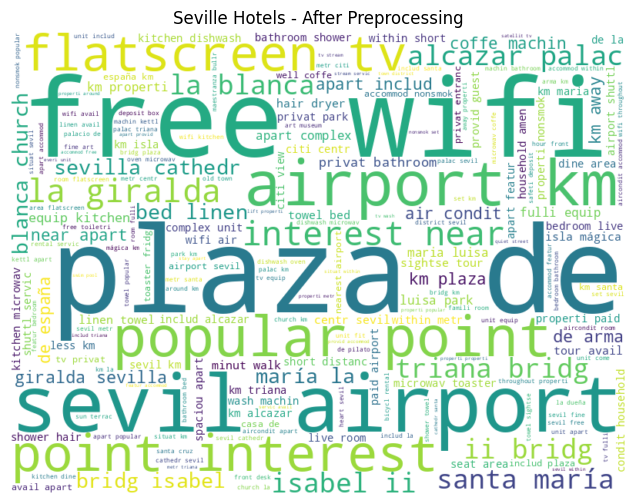

In [84]:
# Preprocess text for both cities
df_BCN_processed = preprocess_text(df_BCN_desc)
df_SVL_processed = preprocess_text(df_SVL_desc)
wordcloud_bcn_proc = WordCloud(width=800, height=600, background_color='white').generate(df_BCN_processed)
wordcloud_svl_proc = WordCloud(width=800, height=600, background_color='white').generate(df_SVL_processed)

# Save Barcelona wordcloud
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud_bcn_proc, interpolation='bilinear')
plt.axis('off')
plt.title('Barcelona Hotels - After Preprocessing')
plt.savefig('BCN_after.png', bbox_inches='tight', pad_inches=0)
plt.close()

# Save Seville wordcloud
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud_svl_proc, interpolation='bilinear')
plt.axis('off')
plt.title('Seville Hotels - After Preprocessing')
plt.savefig('SVL_after.png', bbox_inches='tight', pad_inches=0)



# Difference in Difference Regression

In [85]:
# DiD = 1 if city==treated AND time_period==post
df_final['DiD'] = df_final['city'] * df_final['time_period']
df_final['log_price'] = np.log(df_final['price'])
# Drop any rows with missing values in key columns
df_final_clean = df_final.dropna(subset=[
    'log_price', 'id', 'city', 'time_period','DiD',
    'rating'
])


formula = """
log_price ~
C(city) +
C(time_period) +
DiD +
rating
"""

# Fit the model using statsmodels' formula API with clustering:
model = smf.ols(formula=formula, data=df_final_clean).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_final_clean['id']}
)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     114.6
Date:                Fri, 31 Jan 2025   Prob (F-statistic):           5.38e-85
Time:                        16:54:45   Log-Likelihood:                -1297.8
No. Observations:                2379   AIC:                             2606.
Df Residuals:                    2374   BIC:                             2634.
Df Model:                           4                                         
Covariance Type:              cluster                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.3788    

In [86]:
# Pool features
pool_pattern = r'(?:outdoor|indoor|rooftop|seasonal)\s*(?:swimming\s*)?pool'

# WiFi availability
wifi_pattern = r'(?:free|complimentary)\s*(?:Wi-?Fi|wireless|internet)'

# Air conditioning
ac_pattern = r'air[- ]condition(?:ed|ing)'

# TV features
tv_pattern = r'(?:flat[- ]screen|smart)\s*TV'

# Room views
view_pattern = r'(?:views?|overlooking)\s+(?:of\s+)?(?:the\s+)?([A-Za-z\s]+(?:sea|city|beach|garden|port|cathedral|mountain|street))'

# Balcony/terrace
balcony_pattern = r'(?:private|furnished)?\s*(?:balcony|terrace)'

# Airport services
airport_pattern = r'(?:airport|shuttle)\s*(?:transfer|service|bus)'

# Parking options
parking_pattern = r'(?:private|public)?\s*parking\s*(?:is\s*)?(?:available|offered)'

# Hotel style/type
style_pattern = r'(?:boutique|luxury|design|modern)\s*hotel'

In [87]:
def extract_features(description):
    description = str(description).lower()

    # Create feature dictionary
    features = {
        'has_pool': 1 if re.search(pool_pattern, description, re.IGNORECASE) else 0,
        'has_wifi': 1 if re.search(wifi_pattern, description, re.IGNORECASE) else 0,
        'has_ac': 1 if re.search(ac_pattern, description, re.IGNORECASE) else 0,
        'has_tv': 1 if re.search(tv_pattern, description, re.IGNORECASE) else 0,
        'has_view': 1 if re.search(view_pattern, description, re.IGNORECASE) else 0,
        'has_balcony': 1 if re.search(balcony_pattern, description, re.IGNORECASE) else 0,
        'has_airport_service': 1 if re.search(airport_pattern, description, re.IGNORECASE) else 0,
        'is_boutique_luxury': 1 if re.search(style_pattern, description, re.IGNORECASE) else 0
    }
    return features


In [88]:
# Create features
feature_df = pd.DataFrame([extract_features(desc) for desc in df_final['description']])
# Reset index of both dataframes
df_final = df_final.reset_index(drop=True)
feature_df = feature_df.reset_index(drop=True)
# Concatenate
df_final = pd.concat([df_final, feature_df], axis=1)

In [89]:
# Drop any rows with missing values in key columns
df_final_clean = df_final.dropna(subset=[
    'log_price', 'id', 'city', 'time_period','DiD',
    'rating', 'has_pool', 'has_wifi', 'has_ac',
    'has_tv', 'has_view', 'has_balcony',
    'has_airport_service', 'is_boutique_luxury'
])


formula = """
log_price ~
C(city) +
C(time_period) +
DiD +
rating +
has_pool +
has_wifi +
has_ac +
has_tv +
has_view +
has_balcony +
has_airport_service +
is_boutique_luxury
"""

# Fit the model using statsmodels' formula API with clustering:
model = smf.ols(formula=formula, data=df_final_clean).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_final_clean['id']}
)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     53.82
Date:                Fri, 31 Jan 2025   Prob (F-statistic):          4.51e-107
Time:                        16:54:46   Log-Likelihood:                -1206.6
No. Observations:                2379   AIC:                             2439.
Df Residuals:                    2366   BIC:                             2514.
Df Model:                          12                                         
Covariance Type:              cluster                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.3611    

# Decomposing the Treatment Effect by Hotel Quality

In [90]:
df_final['HQ_DiD'] = df_final['is_boutique_luxury'] * df_final['DiD']

df_final_clean = df_final.dropna(subset=[
    'log_price', 'id', 'city', 'time_period','DiD','HQ_DiD',
    'rating', 'has_pool', 'has_wifi', 'has_ac',
    'has_tv', 'has_view', 'has_balcony',
    'has_airport_service', 'is_boutique_luxury'
])

In [91]:
formula = """
log_price ~
C(city) +
C(time_period) +
DiD +
HQ_DiD +
rating +
has_pool +
has_wifi +
has_ac +
has_tv +
has_view +
has_balcony +
has_airport_service +
is_boutique_luxury
"""

# Fit the model using statsmodels' formula API with clustering:
model = smf.ols(formula=formula, data=df_final_clean).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_final_clean['id']}
)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     49.87
Date:                Fri, 31 Jan 2025   Prob (F-statistic):          1.24e-106
Time:                        16:54:46   Log-Likelihood:                -1205.1
No. Observations:                2379   AIC:                             2438.
Df Residuals:                    2365   BIC:                             2519.
Df Model:                          13                                         
Covariance Type:              cluster                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.3655    